# PyTorch GAN

## References
* [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)
* [Improved Techniques for Training GANs](http://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf)

## Load Data

In [1]:
import matplotlib
%matplotlib inline

from torchvision import transforms, datasets, utils
import torch
import matplotlib.pyplot as plt
import numpy as np
from random import choice

In [2]:
tfms = transforms.ToTensor()

In [3]:
trainset = datasets.MNIST(root='~/Code/dl/datasets', train=True, download=True, transform=tfms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
print(f'Number of training samples: {len(trainset)}')

testset = datasets.MNIST(root='~/Code/dl/datasets', train=False, download=True, transform=tfms)
testloader = torch.utils.data.DataLoader(testset, batch_size=4096, shuffle=True, num_workers=4)
print(f'Number of testing samples: {len(testset)}')

Number of training samples: 60000
Number of testing samples: 10000


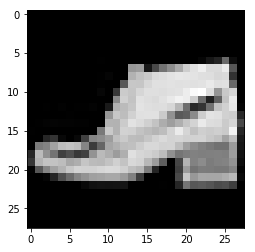

In [4]:
plt.imshow(np.squeeze(choice(trainset)[0]), cmap='gray')

In [5]:
dimensions = (1, 28, 28)
img_length = int(np.prod(dimensions))

## Define Models and Loss

In [6]:
from torch import nn

In [7]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [8]:
device = torch.device('cuda')
z_length = 20

generator = nn.Sequential(
    Flatten(),
    nn.Linear(z_length, 300),
    nn.ReLU(),
    nn.Linear(300, img_length),
    nn.ReLU()
).to(device)

In [9]:
def get_generator_loss():
    z = torch.randn((batch_size, z_length)).to(device)
    return -1 * torch.mean(torch.log(discriminator(generator(z))))

In [10]:
discriminator = nn.Sequential(
    Flatten(),
    nn.Linear(img_length, 300),
    nn.ReLU(),
    nn.Linear(300, 1),
    nn.Sigmoid(),
#     Debug()
).to(device)

In [11]:
def get_discriminator_loss():
    z = torch.randn((batch_size, z_length)).to(device)
    loss = torch.log(discriminator(x)) + torch.log(1 - discriminator(generator(z)))
    loss = -1 * torch.mean(loss)
    return loss

## Training

In [12]:
generator_optim = torch.optim.Adam(generator.parameters(), lr=1e-4)
discriminator_optim = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

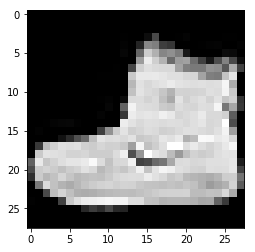

In [13]:
plt.imshow(trainset[0][0].squeeze(), cmap='gray')

In [14]:
disc_steps = 1 # k in the paper
epochs = 20
for i in range(epochs):
    print(f'Epoch {i+1}/{epochs}')
    
    epoch_disc_loss = 0.0
    epoch_gen_loss = 0.0
    
    for i, (x, _) in enumerate(trainloader):
        batch_size = x.size()[0]
        x = x.to(device)
        
        generator_optim.zero_grad()
        discriminator_optim.zero_grad()
        
        for j in range(disc_steps):
            discriminator_loss = get_discriminator_loss()
            epoch_disc_loss += discriminator_loss
            discriminator_loss.backward()
            discriminator_optim.step()

        generator_loss = get_generator_loss()
        epoch_gen_loss += generator_loss
        generator_loss.backward()
        generator_optim.step()
    
    print(f'Average generator loss {epoch_gen_loss / len(trainloader)}')
    print(f'Average discriminator loss {epoch_disc_loss / (len(trainloader) * disc_steps)}')

Epoch 1/20
Average generator loss 1.5627648830413818
Average discriminator loss 0.5409525632858276
Epoch 2/20
Average generator loss 1.7363580465316772
Average discriminator loss 0.5194142460823059
Epoch 3/20
Average generator loss 1.6775398254394531
Average discriminator loss 0.5978693962097168
Epoch 4/20
Average generator loss 1.5274986028671265
Average discriminator loss 0.6819452047348022
Epoch 5/20
Average generator loss 1.490682601928711
Average discriminator loss 0.7724573612213135
Epoch 6/20
Average generator loss 1.3815150260925293
Average discriminator loss 0.8220398426055908
Epoch 7/20
Average generator loss 1.4156230688095093
Average discriminator loss 0.7971274256706238
Epoch 8/20
Average generator loss 1.3505247831344604
Average discriminator loss 0.8422993421554565
Epoch 9/20
Average generator loss 1.3926372528076172
Average discriminator loss 0.8064237833023071
Epoch 10/20
Average generator loss 1.39400053024292
Average discriminator loss 0.8298877477645874
Epoch 11/20


In [15]:
def sample(n_samples=1):
    images = []
    for i in range(n_samples):
        z = torch.randn((1, z_length)).to(device)
        gen = generator(z)
        images.append(gen.view(dimensions).detach().cpu())

    grid = utils.make_grid(images)
    plt.imshow(np.transpose(grid, (1, 2, 0)))

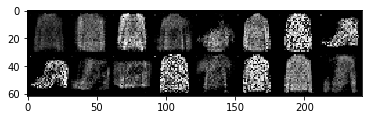

In [16]:
sample(16)